In [1]:
import os, sys, json, pandas
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
from typing import Dict

filepath = os.path.join(sys.path[0], "..", "src", "assets", "rooms.json")
with open(filepath) as f:
    data = json.load(f)

In [2]:
def roundTime(dt: datetime = None, dateDelta: timedelta = timedelta(minutes=15)) -> datetime:
    """Round a datetime object to a multiple of a timedelta
    dt : datetime.datetime object, default now.
    dateDelta : timedelta object, we round to a multiple of this, default 1 minute.
    Author: Thierry Husson 2012 - Use it as you want but don't blame me.
            Stijn Nevens 2014 - Changed to use only datetime objects as variables
    """
    roundTo = dateDelta.total_seconds()

    if dt == None : dt = datetime.datetime.now()
    seconds = (dt - dt.min).seconds
    # // is a floor division, not a comment on following line:
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + timedelta(0,rounding-seconds,-dt.microsecond)

In [3]:
def zerofill(dates: Dict[datetime, int], delta: timedelta = timedelta(minutes=15)):
    '''Fills a sorted date: value dict with zeros if there are gaps in the specified delta.'''
    min_date, max_date = min(dates.keys()), max(dates.keys())
    curr_date = min_date
    while curr_date < max_date:
        if not dates.get(curr_date, None):
            dates[curr_date] = 0
        curr_date += delta
    return dates

In [4]:
# Export lunch time schedule
today = datetime.today().strftime("%d.%m.%Y")
events = {}
# Go though each event and count courses
for room_events in data["events_by_date"][today].values():
    for event in room_events:
        end = roundTime(datetime.strptime(event["end"], "%Y-%m-%dT%H:%M:%SZ"))
        if end.time() >= time(11) and end.time() < time(14):
            for date in [end, end + timedelta(minutes=15), end + timedelta(minutes=30)]:
                if end.hour >= 14:
                    continue
                if events.get(date, None):
                    events[date] += 1
                else:
                    events[date] = 1
# Zerofill events dict
events = zerofill(events)
# Build sorted events list
events_list = sorted(list(events.items()), key=lambda e: e[0])
y_series = [v for _, v in events_list]
x_series = [k for k, _ in events_list]

In [ ]:

# Create plot
frame = pandas.DataFrame(events_list, columns=["Uhrzeit", "Anzahl Kurse in Mittagspause"]).set_index("Uhrzeit")
# Style plot
plt.style.use('seaborn')
ax = frame.plot(kind="bar", rot=0, color='#4C72B0')
figure = ax.get_figure()
ax.set_facecolor('#EAEAF2')
ax.get_figure().set_facecolor('white')
ax.set_ylabel("Anzahl Kurse", fontsize=16, fontweight='bold')
ax.set_xlabel("Uhrzeit", fontsize=16, fontweight='bold')
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=2)
ax.xaxis.grid(False)
legend = ax.legend(fontsize="large", frameon=True, framealpha=1)
legend.get_frame().set_linewidth(0.0)
ax.set_ylim(top=max(y_series) + 4)
# Set x tick labels
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xticklabels([date.strftime("%H:%M") for date in x_series])
# Add bar values
props = dict(facecolor='#EAEAF2', alpha=1, edgecolor='none')
for i, v in enumerate(y_series):
    ax.text(i, v + 1, str(v), color='tab:blue', fontweight='bold', ha='center', fontsize=12, alpha=1, bbox=props)


In [ ]:
# Export plot
figure.savefig("mensa_light.png", bbox_inches='tight', dpi=200, facecolor=figure.get_facecolor(), edgecolor='none')

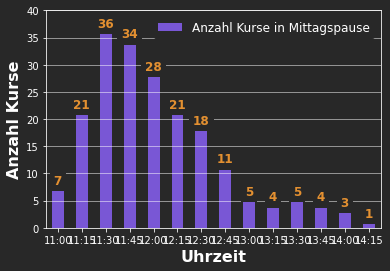

In [5]:
# Create plot
frame = pandas.DataFrame(events_list, columns=["Uhrzeit", "Anzahl Kurse in Mittagspause"]).set_index("Uhrzeit")
# Style plot
plt.style.use('dark_background')
ax = frame.plot(kind="bar", rot=0, color='#7957d5')
figure = ax.get_figure()
ax.set_facecolor('#282828')
ax.get_figure().set_facecolor('#282828')
ax.set_ylabel("Anzahl Kurse", fontsize=16, fontweight='bold')
ax.set_xlabel("Uhrzeit", fontsize=16, fontweight='bold')
ax.yaxis.grid(True, which='major', linestyle='-', linewidth=0.5)
ax.xaxis.grid(False)
legend = ax.legend(fontsize="large", frameon=True, facecolor='#282828', framealpha=1)
legend.get_frame().set_linewidth(0.0)
ax.set_ylim(top=max(y_series) + 4)
# Set x tick labels
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xticklabels([date.strftime("%H:%M") for date in x_series])
# Add bar values
props = dict(facecolor='#282828', alpha=1, edgecolor='none')
for i, v in enumerate(y_series):
    ax.text(i, v + 1, str(v), color='#E39031', fontweight='bold', ha='center', fontsize=12, alpha=1, bbox=props)

In [ ]:
# Export plot
figure.savefig("mensa_dark.png", bbox_inches='tight', dpi=200, facecolor=figure.get_facecolor(), edgecolor='none')